In [49]:
%load_ext autoreload
%autoreload 2

import pickle
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Funciones
# -----------------------------------------------------------------------
import sys
sys.path.append('../')
import src.funciones as f
import src.soporte_prep as spp
import src.soporte_encoding as se
import src.soporte_logistica as sl


# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
df = pd.read_csv('../../Datos/Datos_Modelo_1/Modelo_1_CL_0.csv', index_col=0) # importo mi modelo más importante
df.head()

,Sales,Shipping Cost,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Order Priority_Critical,Order Priority_High,Order Priority_Low,Order Priority_Medium,Market,Category,Sub-Category,Discount_Category,Quantity_Group
0,5175.171,36.402569,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,388.376416,547.018128,618.799551,315.400165,609.607347
1,2892.510,36.188641,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,325.114659,551.240787,592.774328,317.592607,219.059908
2,2862.675,35.674493,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,386.588755,557.301946,599.827583,315.266028,215.647828
3,1822.080,35.570941,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,399.982921,484.398507,504.014715,318.889702,219.976199
4,5083.960,34.484046,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,288.915258,141.579897,97.821329,315.400165,215.979321


In [51]:
x= df.drop(columns='Sales')
y = df[['Sales']]

In [52]:
def metricas(y_train, y_train_pred, y_test, y_test_pred):
    metricas = {
    'train': {
        'r2_score': r2_score(y_train, y_train_pred),
        'MAE': mean_absolute_error(y_train, y_train_pred),
        'MSE': mean_squared_error(y_train, y_train_pred),
        'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred))
    },
    'test': {
        'r2_score': r2_score(y_test, y_test_pred),
        'MAE': mean_absolute_error(y_test, y_test_pred),
        'MSE': mean_squared_error(y_test, y_test_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))

    }
    }

    return pd.DataFrame(metricas).T

In [53]:
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size=0.7, random_state=42)

In [54]:
modelo_lineal = LinearRegression()
modelo_lineal.fit(x_train, y_train) # aprendizaje

LinearRegression()

In [55]:
y_train_pred = modelo_lineal.predict(x_train)
y_train_pred[:3]

array([[440.683228  ],
       [702.96755588],
       [-18.66219228]])

In [56]:
y_test_pred = modelo_lineal.predict(x_test) # predicciones, con xtest porque xtest son sus parametros. ytest son las respuestas con las que comparemos
y_test_pred[:3]

array([[257.72506125],
       [397.63367363],
       [843.39461889]])

In [57]:
y_test = np.array(y_test).ravel()
y_test_pred = np.array(y_test_pred).ravel()

In [58]:
metricas(y_train,y_train_pred,y_test,y_test_pred)

,r2_score,MAE,MSE,RMSE
train,0.571725,145.058389,170169.84930,412.516484
test,0.702220,139.073625,94769.88918,307.847185


Las métricas no son muy buenas, a primera instancia nos podemos dar cuenta de que el conjunto test tiene underfitting: tengo un error bajo en el conjunto train pero unos valores mejores para el test. No está aprendiendo bien del conjunto de entrenamiento por lo que está generalizando las predicciones. Vemos una diferencia de r2 pero una importante distancia entre ambos conjuntos para el RMSE. Posiblemente es un modelo muy simple, podría decirse que mis variables predictoras no están haciendo su trabajo.

Text(0, 0.5, 'Predicciones (y_test_pred)')

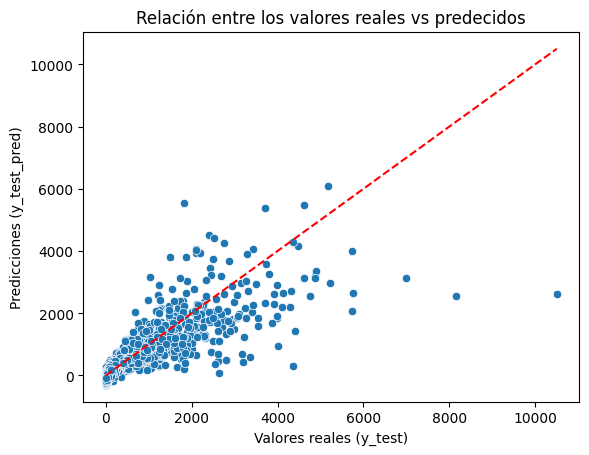

In [59]:
sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x = [min(y_test), max(y_test)], y = [min(y_test), max(y_test)], markersize = 1, color = "red", linestyle = "--")

plt.title('Relación entre los valores reales vs predecidos')
plt.xlabel('Valores reales (y_test)')
plt.ylabel('Predicciones (y_test_pred)')

## Decision Tree

In [60]:
params_arbol = {
    'max_depth': [4, 7,10,14],
    'min_samples_split': [10, 50, 100, 200],
    'min_samples_leaf': [10, 15, 20, 30],
    'max_leaf_nodes': [6, 8, 10, 20, 30]
}

In [61]:
params_arbol_2 = {
    'max_depth': [6, 7,8,9],
    'min_samples_split': [40,50,60],
    'min_samples_leaf': [18, 20,21],
    'max_leaf_nodes': [25,28,30,32,35]
}

In [62]:
params_arbol_3 = {
    'max_depth': [6, 7,8,9],
    'min_samples_split': [15, 50, 100],
    'min_samples_leaf': [20,30,40],
    'max_leaf_nodes': [32,35,40,42]
}

In [63]:
params_arbol_4 = {
    'max_depth': [3,4,5,6,7],
    'min_samples_split': [15, 50, 100],
    'min_samples_leaf': [20,30,40],
    'max_leaf_nodes': [32,35,40,42]
}

In [64]:
params_arbol_5 = {
    'max_depth': [5],
    'min_samples_split': [45,50,55],
    'min_samples_leaf': [17,20,22],
    'max_leaf_nodes': [38,40,42]
}

In [65]:
grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid=params_arbol_5,
                                 cv = 5,
                                 scoring= 'neg_mean_squared_error',
                                 n_jobs=-1)
grid_search_arbol.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5], 'max_leaf_nodes': [38, 40, 42],
                         'min_samples_leaf': [17, 20, 22],
                         'min_samples_split': [45, 50, 55]},
             scoring='neg_mean_squared_error')

In [66]:
modelo_final_arbol = grid_search_arbol.best_estimator_

In [67]:
modelo_final_arbol

DecisionTreeRegressor(max_depth=5, max_leaf_nodes=38, min_samples_leaf=20,
                      min_samples_split=50)

In [68]:
y_test_pred_final = modelo_final_arbol.predict(x_test)
y_train_pred_final = modelo_final_arbol.predict(x_train)

In [69]:
df_metricas_arbol = metricas(y_train, y_train_pred_final, y_test, y_test_pred_final)

In [70]:
df_metricas_arbol

,r2_score,MAE,MSE,RMSE
train,0.646546,107.801445,140440.721632,374.754215
test,0.791783,103.657813,66266.076405,257.421981


Después de probar con varios hiperparámetros, las métricas siguen sin ser las mejores aunque sigue ocurriendo underfitting. Mantengo la idea de que mis variables no están haciendo buenas predicciones.

In [71]:
df_resultados_arbol = pd.DataFrame(grid_search_arbol.cv_results_).sort_values(by = 'rank_test_score', ascending=True)
df_resultados_arbol.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.088027,0.034829,0.007417,0.002585,5,38,20,50,"{'max_depth': 5, 'max_leaf_nodes': 38, 'min_sa...",-116679.214505,-108403.864513,-75204.499663,-402008.666836,-68265.035348,-154112.256173,125331.001318,1
22,0.075621,0.022729,0.012122,0.011248,5,42,20,50,"{'max_depth': 5, 'max_leaf_nodes': 42, 'min_sa...",-116679.214505,-108403.864513,-75204.499663,-402008.666836,-68265.035348,-154112.256173,125331.001318,2
13,0.103623,0.057322,0.008434,0.004633,5,40,20,50,"{'max_depth': 5, 'max_leaf_nodes': 40, 'min_sa...",-116679.214505,-108403.864513,-75204.499663,-402008.666836,-68265.035348,-154112.256173,125331.001318,3
1,0.047552,0.011790,0.012120,0.010036,5,38,17,50,"{'max_depth': 5, 'max_leaf_nodes': 38, 'min_sa...",-117074.324772,-108403.864513,-75055.875999,-402130.653060,-68265.035348,-154185.950738,125374.495046,4
19,0.140376,0.060152,0.007343,0.002502,5,42,17,50,"{'max_depth': 5, 'max_leaf_nodes': 42, 'min_sa...",-117074.324772,-108403.864513,-75055.875999,-402130.653060,-68265.035348,-154185.950738,125374.495046,4
10,0.090435,0.038461,0.021457,0.025054,5,40,17,50,"{'max_depth': 5, 'max_leaf_nodes': 40, 'min_sa...",-117074.324772,-108403.864513,-75055.875999,-402130.653060,-68265.035348,-154185.950738,125374.495046,6
3,0.095103,0.062872,0.006011,0.001716,5,38,20,45,"{'max_depth': 5, 'max_leaf_nodes': 38, 'min_sa...",-116679.214505,-109158.335968,-75204.499663,-402008.666836,-68265.035348,-154263.150464,125276.321374,7
21,0.189309,0.074605,0.019958,0.015208,5,42,20,45,"{'max_depth': 5, 'max_leaf_nodes': 42, 'min_sa...",-116679.214505,-109158.335968,-75204.499663,-402008.666836,-68265.035348,-154263.150464,125276.321374,7
12,0.059421,0.006541,0.006520,0.001103,5,40,20,45,"{'max_depth': 5, 'max_leaf_nodes': 40, 'min_sa...",-116679.214505,-109158.335968,-75204.499663,-402008.666836,-68265.035348,-154263.150464,125276.321374,9
18,0.100208,0.029488,0.019323,0.023108,5,42,17,45,"{'max_depth': 5, 'max_leaf_nodes': 42, 'min_sa...",-117074.324772,-109158.335968,-75055.875999,-402130.653060,-68265.035348,-154336.845029,125319.745346,10


In [72]:
df_resultados_arbol_filtrado = df_resultados_arbol.filter(like='param').drop(columns='params')
df_resultados_arbol_filtrado['MSE'] = df_resultados_arbol['mean_test_score']
df_resultados_arbol_filtrado

,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,MSE
4,5,38,20,50,-154112.256173
22,5,42,20,50,-154112.256173
13,5,40,20,50,-154112.256173
1,5,38,17,50,-154185.950738
19,5,42,17,50,-154185.950738
10,5,40,17,50,-154185.950738
3,5,38,20,45,-154263.150464
21,5,42,20,45,-154263.150464
12,5,40,20,45,-154263.150464
18,5,42,17,45,-154336.845029


In [73]:
df_rmse_prof = np.sqrt(df_resultados_arbol_filtrado.groupby('param_max_depth')['MSE'].mean().abs()).reset_index()

In [74]:
df_rmse_prof

,param_max_depth,MSE
0,5,393.71071


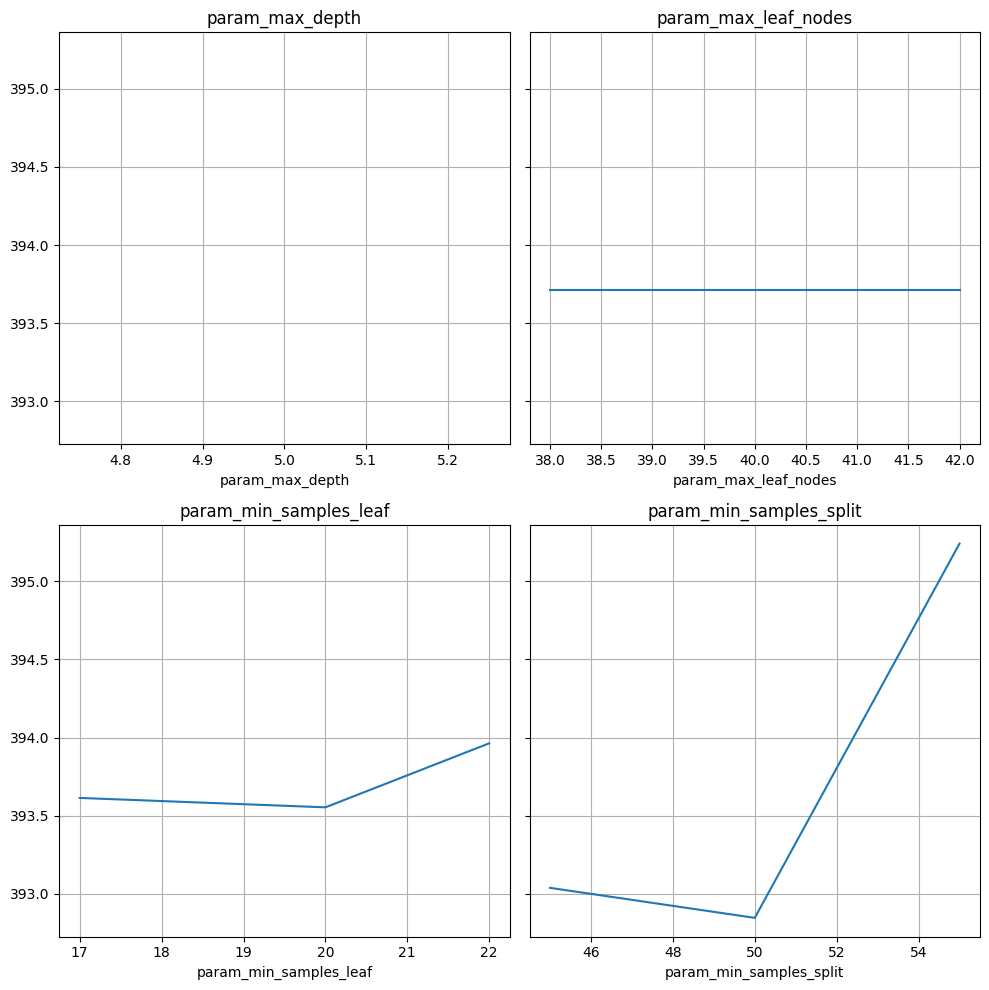

In [75]:
# df_rmse_prof = np.sqrt(df_resultados_arbol_filtrado.groupby("param_max_depth")["MSE"].mean().abs())
# df_rmse_prof = pd.DataFrame(df_rmse_prof).reset_index()

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10), sharey=True)
axes = axes.flat

for indice, column in enumerate(df_resultados_arbol_filtrado.columns[:-1]):
    # Asegurarse de no exceder el número de subgráficos
    if indice >= len(axes):
        break

    df_rmse_col = np.sqrt(df_resultados_arbol_filtrado.groupby(column)["MSE"].mean().abs())

    sns.lineplot(x=df_rmse_col.index, y=df_rmse_col.values, ax=axes[indice])
    axes[indice].grid()
    axes[indice].set_title(column)

plt.tight_layout()
plt.show() 

In [76]:
df_importancia = pd.DataFrame(modelo_final_arbol.feature_importances_,columns = ['Importancia'], index=x.columns).sort_values(by='Importancia', ascending=False)

<Axes: xlabel='Importancia', ylabel='None'>

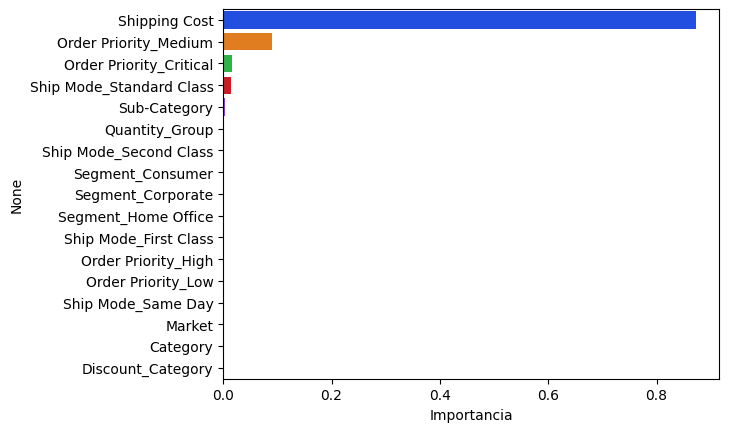

In [77]:
sns.barplot(x='Importancia', y=df_importancia.index ,data=df_importancia, palette='bright')

La columna de Shipping Cost es la única con cierta relevancia sobre mis predicciones, por encima de un 80%.

## Random Forest

In [78]:
params_rrf = {
    'n_estimators': [100, 250, 500,1000],
    'max_features': [2,4,8,12,16],
    'max_depth': [5,6,7],
    'min_samples_split': [45,50,55],
    'min_samples_leaf': [20], 
    'max_leaf_nodes': [45,50,55]
}

modelo_rrf = RandomForestRegressor(random_state=42, bootstrap=True,n_jobs=-1) # por este método nos pide un array

randonmized_rrf = RandomizedSearchCV(modelo_rrf, # solo hace las iteraciones que le digo
                              params_rrf,
                              cv = 5,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1,
                              random_state=50, #semilla
                              n_iter=10,
                              verbose=10)

randonmized_rrf.fit(x_train, y_train['Sales'].values) # array de una dim
modelo_final_rrf = randonmized_rrf.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [79]:
modelo_final_rrf

RandomForestRegressor(max_depth=7, max_features=16, max_leaf_nodes=50,
                      min_samples_leaf=20, min_samples_split=45,
                      n_estimators=250, n_jobs=-1, random_state=42)

In [80]:
y_pred_test_rrf = modelo_final_rrf.predict(x_test)
y_pred_train_rrf = modelo_final_rrf.predict(x_train)
df_metricas_rrf = metricas(y_train, y_pred_train_rrf, y_test, y_pred_test_rrf)
df_metricas_rrf

,r2_score,MAE,MSE,RMSE
train,0.677669,95.145514,128074.382174,357.874814
test,0.818685,92.122437,57704.324726,240.217245


Podemos observar que se mantiene el underfitting. A pesar de utilizar distintos métodos, nos damos cuenta de que nuestra variables seleciconadas no están rindiendo para unas correctas predicciones.

### Random Distinto

In [81]:
params_rf = {
    'n_estimators': [225,250,300],
    'max_features': [15,18,20,22],
    'max_depth': [1,2,3,5,7,9],
    'min_samples_split': [42,45,28,50],
    'min_samples_leaf': [19,20,21], 
    'max_leaf_nodes': [50]
}

modelo_rf = RandomForestRegressor(random_state=42, bootstrap=True) # por este método nos pide un array

grid_search_rf = GridSearchCV(modelo_rf,
                              params_rf,
                              cv = 5,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1,
                              )

grid_search_rf.fit(x_train, y_train['Sales'].values) # array de una dim
modelo_final_rf = grid_search_rf.best_estimator_

In [82]:
modelo_final_rf

RandomForestRegressor(max_depth=9, max_features=15, max_leaf_nodes=50,
                      min_samples_leaf=19, min_samples_split=28,
                      n_estimators=225, random_state=42)

In [83]:
y_pred_test_rf = modelo_final_rf.predict(x_test)
y_pred_train_rf = modelo_final_rf.predict(x_train)
df_metricas_rf = metricas(y_train, y_pred_train_rf, y_test, y_pred_test_rf)
df_metricas_rf

,r2_score,MAE,MSE,RMSE
train,0.681835,95.454141,126418.883699,355.554333
test,0.822438,92.444278,56510.040880,237.718407


## Gradient Booster

In [84]:
params_gb = {
    'n_estimators': [115,150,200],
    'learning_rate': [0.01,0.1,0.2],
    'max_depth': [3],
    'min_samples_split': [100],
    'min_samples_leaf': [20], 
}

modelo_gb = GradientBoostingRegressor(random_state=42) # por este método nos pide un array

grid_search_gb = GridSearchCV(modelo_gb,
                              params_gb,
                              cv = 5,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1)

grid_search_gb.fit(x_train, y_train['Sales'].values) # array de una dim
modelo_final_gb = grid_search_gb.best_estimator_

In [85]:
modelo_final_gb

GradientBoostingRegressor(min_samples_leaf=20, min_samples_split=100,
                          n_estimators=150, random_state=42)

In [86]:
y_pred_test_gb = modelo_final_gb.predict(x_test)
y_pred_train_gb = modelo_final_gb.predict(x_train)
df_metricas_gb = metricas(y_train, y_pred_train_gb, y_test, y_pred_test_gb)
df_metricas_gb

,r2_score,MAE,MSE,RMSE
train,0.709826,92.799884,115296.946251,339.554040
test,0.836539,91.005188,52022.231989,228.083827


## XGB

In [88]:
params_xgb = {
    'n_estimators': [70],
    'learning_rate': [0.01, 0.05,0.1],
    'max_depth': [3],
    'min_child_weight': [6,7],
    'subsample': [0.8], 
    'colsample_bytree': [0.25]
}

modelo_xgb = XGBRegressor(random_state=42) # por este método nos pide un array

grid_search_xgb = GridSearchCV(modelo_xgb,
                              params_xgb,
                              cv = 3,
                              scoring='neg_mean_squared_error',
                              n_jobs=-1)

grid_search_xgb.fit(x_train, y_train['Sales'].values) # array de una dim
modelo_final_xgb = grid_search_xgb.best_estimator_

In [89]:
modelo_final_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.25, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=70, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [90]:
y_pred_test_xgb = modelo_final_xgb.predict(x_test)
y_pred_train_xgb = modelo_final_xgb.predict(x_train)
df_metricas_xgb = metricas(y_train, y_pred_train_xgb, y_test, y_pred_test_xgb)
df_metricas_xgb

,r2_score,MAE,MSE,RMSE
train,0.650893,115.876686,138713.254347,372.442283
test,0.795905,112.273890,64954.110313,254.860963


En resumen, este modelo no está haciendo las predicciones correctamente ya que cuenta con algo constante: underfitting.